<a href="https://colab.research.google.com/github/afarley9/perovskites/blob/main/examples/Linear_regression_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading and Lasso Linear regression example for Log(Ld80) prediction with and without the use of PL images.
## **Note that the training data is available only to the members to the team. So, only the team members can access the master index csv file.**

This is how Google colab's `mount` is being used to read data directly from the drive without downloading or uploading. By directly routing data to the Colab's virtual machine, we will be able stream line it directly into the neural network being built by other team folks.



In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import json

from sklearn.model_selection import train_test_split

# Mount the drive and clone the github repo
drive.mount('/content/drive/')

Mounted at /content/drive/


This is how the github [repository](https://github.com/afarley9/perovskites) is being cloned into the virtual machine and loaded.

In [ ]:
!git clone https://github.com/afarley9/perovskites.git

# Import modules from the github repo
sys.path.append("/content/perovskites/perovskites")
sys.path.append("/content/perovskites")
import utils.image_processing as impr
import utils.image_loader as loader
import utils.miscellaneous as misc
import linreg
import regression_visualization as reg_vis
from utils.autoencoder_to_encoder import autoencoder

Cloning into 'perovskites'...
remote: Enumerating objects: 355, done.
remote: Counting objects: 100% (355/355), done.
remote: Compressing objects: 100% (240/240), done.
remote: Total 1137 (delta 251), reused 210 (delta 115), pack-reused 782
Receiving objects: 100% (1137/1137), 21.97 MiB | 15.27 MiB/s, done.
Resolving deltas: 100% (703/703), done.


The `settings.json` in the perovskites package has all the relevant settings related to the data files and their paths, the model parameters etc, which can be changed by the user and this affects all the models built inside the package.

In [ ]:
with open('/content/perovskites/perovskites/settings.json', 'r') as file:
    model_info = json.load(file)

print(json.dumps(model_info, indent=4))

{
    "target_image_size_um": 50,
    "target_image_size_pix": 32,
    "number_of_clusters": 10,
    "reduced_pca_dims": 10,
    "y_col": "Ld80",
    "FOV_col": "camera_FOV",
    "extract_channel": "true",
    "shared_drive_path": "/content/drive/Shareddrives/Perovskites_DIRECT",
    "data_info": {
        "local_data_folder": "data",
        "pickle_filename": "PL_data.pickle",
        "data_df_filename": "features_intact_filtered.csv",
        "meta_df_filename": "features_meta_filtered.csv"
    },
    "cnn_model_info": {
        "models_folder_path": "models/cnn_saved_models",
        "history_csv_name": "fit_history.csv",
        "model_json_name": "model.json",
        "model_h5_name": "model.h5",
        "fit_json_name": "fit_info.json"
    },
    "linreg_model_info": {
        "models_folder_path": "models/linreg_saved_models",
        "fit_pickle_name": "fit_pickle.pickle"
    }
}


### **Using `image_loader.PLDataLoader()` class to load the dataset**.
All the data can be loaded from the shared google drive using this single class. It has methods for sampling data (`sample()`) and creaing test-train splits (`test_train_split`). The `image_loader` module contains several less frequently used private functions for use if needed.

In [ ]:
# Load the data and create train-split split
dataset = loader.PLDataLoader()
data_tuple = dataset.train_test_split(test_size=0.2,
                                        random_state=42,
                                        shuffle=True,
                                        return_dfs=True)
X_train_img = data_tuple[0]
X_test_img = data_tuple[1]
y_train = data_tuple[2]
y_test = data_tuple[3]
data_df_train = data_tuple[6]
data_df_test = data_tuple[7]

# Prepare X_train and X_test
X_train = data_df_train.values[:, 1:]
X_test = data_df_test.values[:, 1:]
feat_labels = data_df_train.columns[1:]

# Apply log transform
y_train = np.log(y_train)
y_test = np.log(y_test)
y_label = 'log('+model_info['y_col']+'_in_min.)'

print("Total number of features: ", X_train.shape[0])

Total number of features:  996


All the paths to the relevant images and the corresponding experimental metadata are stored in a master csv file which lists details of **1,245 individual degradation experiments**. So this study is going to be done on a well-documented and experimentally collected dataset. But, the challenge is that since the data is experimentally collected and is prone to human-induced and other irreducible noise, it is required to undergo an extensive data-cleaning process to get reliable results. As used above, the `PLDataLoader()` can be used to load the data and also make the test-train splits. ***Note that the dataset is currently available only to the team members due to confidentiality of the data as most of it is unpublished***.


### **Training and saving a Linear Regression model**

* ***Input row*** : 1D array with environmental conditions (like T, RH%, O2%) and early time measurements as features (Ld, PL and Tr measurements at t = 0, 5 etc.) 
* ***Output*** : log(Ld80) prediction values with shape (N,)

We developed a `linear_regression()` function that can take a `model_type` string to select the type of linear regression. For regularized models like Lasso and Ridge, it even uses cross-validation to tune the regularization
hyperparameter.

In [ ]:
model_name = 'training_demo'
linreg_dict = linreg.linear_regressor(X_train, y_train,
                                      X_test, y_test,
                                      feat_labels,
                                      y_label,
                                      model_type='Ridge',
                                      alpha_tuning_params={},
                                      model_folder=model_name,
                                      save_to_drive=True,
                                      overwrite_existing_model=True,
                                    )
model = linreg_dict['fit']
scaler = linreg_dict['scaler']

neg_mean_absolute_percentage_error  is not available in sklearn.metrics. Using
              'neg_mean_absolute_error' instead.

------------------------------------------
Regularization hyperparameter tuning by cv
------------------------------------------
alpha range        :  (1.00e-03, 1.00e-03)
No. of folds       :  5
Maximum iterations :  2
Tolerance          :  1.00e-02
Model type         :  Lasso
Scoring metric     :  neg_mean_absolute_error 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.5s finished


------------------------------------------
The best regularization alpha:  0.199
------------------------------------------

Fitting  Ridge  model on traning dataset...

Model saved as dict in  /content/drive/Shareddrives/Perovskites_DIRECT/models/linreg_saved_models/training_demo/fit_pickle.pickle


You can visualize the model using the functions in the `regression_visualization` module. Some functions have been used here for demonstration.
* `coefficient_bar_char()` function displays the top feature's coefficient with absolute values larger than a given tolerance value. The coeffients which are <font color="green"> **positive are colored green**</font> and those which are <font color="red">**negative are colored red**</font>.
* `parity_legend()` function displays the legend for parity plot's marker styling.
* `styled_parity_plot()` function plots the parity plot with the environmental features as marker style.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


This scoring metric is not available. Returning the
                  mean absolute percentage error instead...

This scoring metric is not available. Returning the
                  mean absolute percentage error instead...



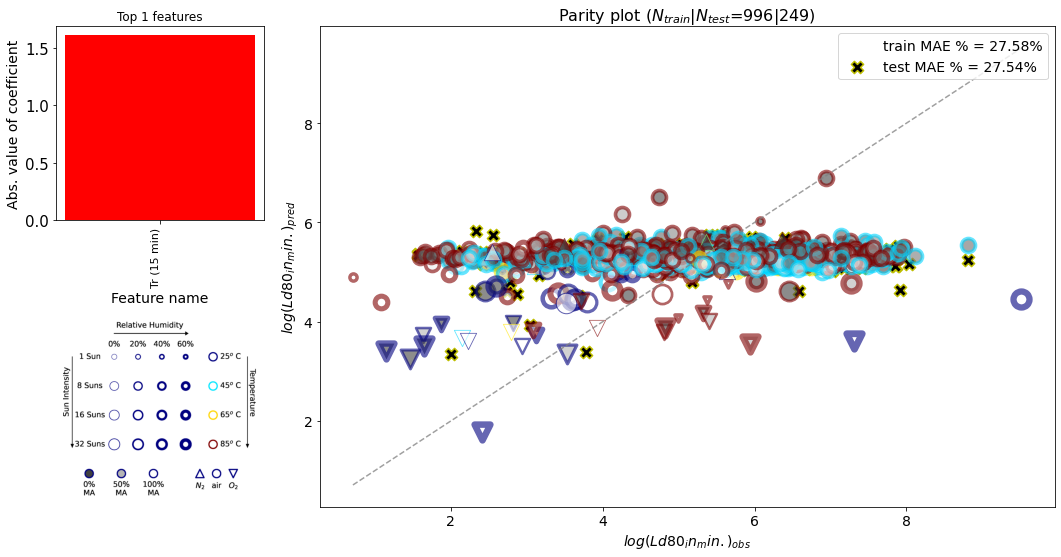

In [ ]:
y_train_pred = model.predict(scaler.transform(X_train))
y_test_pred = model.predict(scaler.transform(X_test))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,8))

# The coefficients plot
_, _, top_feats = reg_vis.coefficient_bar_chart(ax[0, 0], feat_labels,
                                                model.coef_,
                                                tol=1e-2)
ax[0,0].set_title("Top {} features".format(len(top_feats)), fontsize=12)
ax[0, 0].grid(False)

# The legend plot
reg_vis.parity_legend(ax[1, 0], dpi=300)

# # Joining two axes to get a big figure for parity plot
gs = ax[0, 1].get_gridspec()
for a in ax[0:, 1:].flatten():
    a.remove()
big_ax = fig.add_subplot(gs[0:, 1:])
reg_vis.styled_parity_plot(big_ax, y_train=y_train, y_test=y_test,
                           y_train_pred=y_train_pred, y_test_pred=y_test_pred,
                           data_df_train=data_df_train,
                           data_df_test=data_df_test,
                           y_label=y_label
                           )
title_str = 'Parity plot ($N_{train}|N_{test}$'+'={}|{})'.format(len(y_train),
                                                                len(y_test))
big_ax.set_title(title_str, fontsize=16)
big_ax.grid(False)
fig.tight_layout()

The `model_folder` arguement in the `linear_regressor()` function saves the model as a pickle file in `linreg_saved_models` folder with the name in `<model_folder>`. 

In [ ]:
saved_models_path = model_info['linreg_model_info']['models_folder_path']
saved_models_path = model_info['shared_drive_path'] + '/' + saved_models_path
curr_model_path = saved_models_path + '/' + model_name

print("In linreg_saved_models folder in the shared drive:")
!ls $saved_models_path
print("\nIn '"+ model_name+"' folder in the cnn_saved_models:")
!ls $curr_model_path

In linreg_saved_models folder in the shared drive:
training_demo  training_demo_autoencoder

In 'training_demo' folder in the cnn_saved_models:
fit_pickle.pickle


Till now, we haven't incorporated the PL image data into the linear regression model. Let's do that now.

### **Feeding PL image features using an autoencoder's output**

Now, to incorporate the PL image data into the linear regression model, we used an autoencoder to encode 2D image data into 1D arrays each of length 64. First, the autoencoder is run on the entire dataset using the method `core_autoencoder_fxn()` of the `autoencoder` class in the `autoencode_to_encoder` module. This returns the total dataset's encoded arrays and their corresponding indices in the master dataframe.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 8)           1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

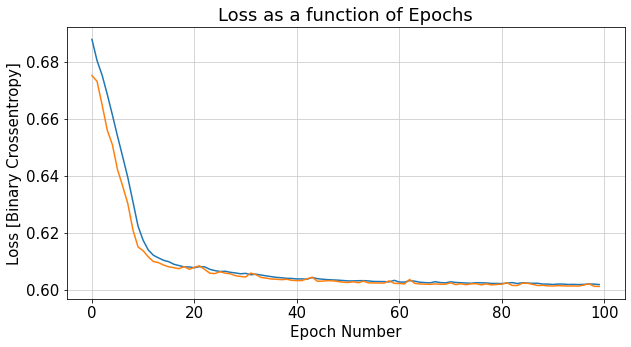

In [ ]:
encoded_array, df_inds = autoencoder(dataset,
                                     h5_name='linreg_autoencoder'
                                    ).core_autoencoder_fxn()

Make the train-test splits and augment the autoencoder data from the PL images, to the experimental features data.

In [ ]:
# Train-test split of entire dataset
inds_train, inds_test = train_test_split(np.arange(len(df_inds)),
                                         test_size=0.2, random_state=42)

df_inds_train = np.array(df_inds)[inds_train]
df_inds_test = np.array(df_inds)[inds_test]

data_df_train = dataset.data_df.loc[df_inds_train]
data_df_test = dataset.data_df.loc[df_inds_test]

# Make the X_train and X_test with autoencoder features
# appended to regular features.
X_train = np.c_[data_df_train.values[:, 1:], encoded_array[inds_train, :]]
y_train = data_df_train.values[:, 0]
X_test = np.c_[data_df_test.values[:, 1:], encoded_array[inds_test, :]]
y_test = data_df_test.values[:, 0]

# Apply log transform
y_train = np.log(y_train)
y_test = np.log(y_test)
y_label = 'log('+model_info['y_col']+'_in_min.)'
encoder_feat_labels = ['AE'+str(i) for i in range(encoded_array.shape[1])]
feat_labels = data_df_train.columns[1:].to_list() + encoder_feat_labels

print("Total number of features: ", X_train.shape[0])

Total number of features:  996


So, the new model is -
* ***Input row*** : 1D array with environmental conditions (like T, RH%, O2%) and early time measurements as features (Ld, PL and Tr measurements at t = 0, 5 etc.) + ***PL features obtained from the Autoencoder***
* ***Output*** : log(Ld80) prediction values with shape (N,)

In [ ]:
model_name = 'training_demo_autoencoder'
ae_linreg_dict = linreg.linear_regressor(X_train, y_train,
                                        X_test, y_test,
                                        feat_labels,
                                        y_label,
                                        model_type='Ridge',
                                        alpha_tuning_params=dict(
                                            alpha_list=[1e-5,1e1],
                                        ),
                                        model_folder=model_name,
                                        save_to_drive=True,
                                        overwrite_existing_model=True,
                                        )
model = ae_linreg_dict['fit']
scaler = ae_linreg_dict['scaler']

neg_mean_absolute_percentage_error  is not available in sklearn.metrics. Using
              'neg_mean_absolute_error' instead.

------------------------------------------
Regularization hyperparameter tuning by cv
------------------------------------------
alpha range        :  (1.00e-05, 1.00e-05)
No. of folds       :  5
Maximum iterations :  2
Tolerance          :  1.00e-02
Model type         :  Lasso
Scoring metric     :  neg_mean_absolute_error 

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    6.9s finished


------------------------------------------
The best regularization alpha:  1e-05
------------------------------------------

Fitting  Ridge  model on traning dataset...

Model saved as dict in  /content/drive/Shareddrives/Perovskites_DIRECT/models/linreg_saved_models/training_demo_autoencoder/fit_pickle.pickle


Visualizing the model using the parity plot and the coefficient plot.

This scoring metric is not available. Returning the
                  mean absolute percentage error instead...

This scoring metric is not available. Returning the
                  mean absolute percentage error instead...



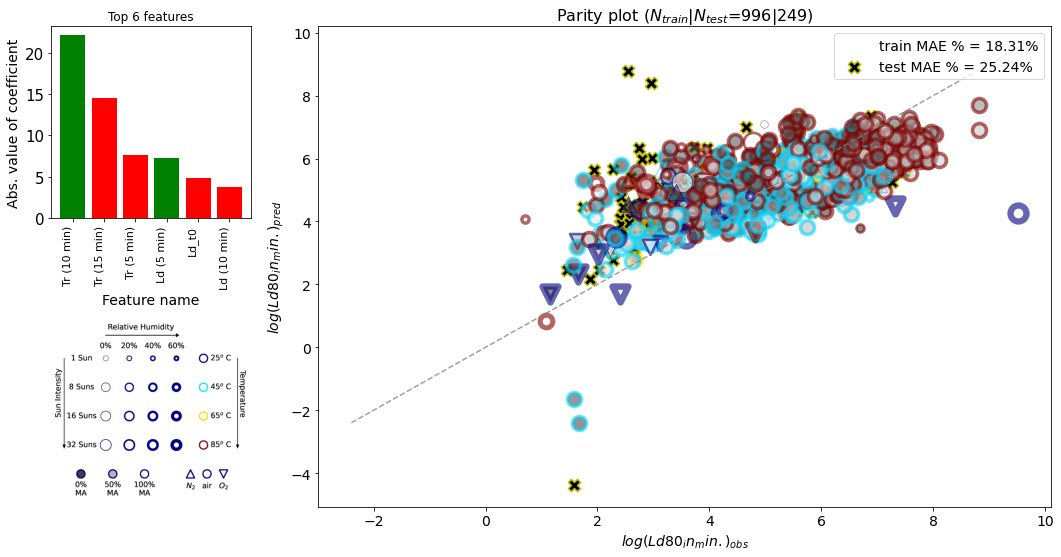

In [ ]:
y_train_pred = model.predict(scaler.transform(X_train))
y_test_pred = model.predict(scaler.transform(X_test))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,8))

# The coefficients plot
_, _, top_feats = reg_vis.coefficient_bar_chart(ax[0, 0], feat_labels, model.coef_,
                              tol=3)
ax[0,0].set_title("Top {} features".format(len(top_feats)), fontsize=12)
ax[0, 0].grid(False)

# The legend plot
reg_vis.parity_legend(ax[1, 0], dpi=300)

# # Joining two axes to get a big figure for parity plot
gs = ax[0, 1].get_gridspec()
for a in ax[0:, 1:].flatten():
    a.remove()
big_ax = fig.add_subplot(gs[0:, 1:])
reg_vis.styled_parity_plot(big_ax, y_train=y_train, y_test=y_test,
                           y_train_pred=y_train_pred, y_test_pred=y_test_pred,
                           data_df_train=data_df_train,
                           data_df_test=data_df_test,
                           y_label=y_label
                           )
title_str = 'Parity plot ($N_{train}|N_{test}$'+'={}|{})'.format(len(y_train),
                                                                len(y_test))
big_ax.set_title(title_str, fontsize=16)
big_ax.grid(False)
fig.tight_layout()


### Autoencoder features show up in the top list of features and effectively encode the variance in the log(Ld80) values. This gives hope that initial time PL images effectively encode the sample-to-sample variation, which cannot be captured by the environmental features.